In [7]:
# import the libraries needed for the analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode, mean, median
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [8]:
# loading the datasets
geo = pd.read_csv("01.geo.csv", encoding='cp1252', sep=";")
custom = pd.read_csv("02.customers.csv", encoding='cp1252', sep=";")
sel = pd.read_csv("03.sellers.csv", encoding='cp1252', sep=";")
ord_status = pd.read_csv("04.order_status.csv", encoding='cp1252', sep=";")
ord_items = pd.read_csv("05.order_items.csv", encoding='cp1252', sep=";")
ord_pay = pd.read_csv("06.order_payments.csv", encoding='cp1252', sep=";")
prod_rev = pd.read_csv("07.product_reviews.csv", encoding='cp1252', sep=";")
prod = pd.read_csv("08.products.csv", encoding='cp1252', sep=";")


In [9]:
# We notice there are 610 NaN values in product_category_name,
# for the purpose of our analysis we substitute them with the category "Others"
prod["product_category_name"].isna().sum()
prod["product_category_name"] = prod["product_category_name"].fillna("Others")


In [10]:
# We added one additional value identifying the number of elements for each order
max_vals = ord_items.groupby("order_id")["order_item_sequence_id"].max().to_dict()
ord_items["max_order"] = ord_items["order_id"].map(max_vals)


In [11]:
# Cleaning the customers df by dropping NaN and duplicates
custom_df = pd.merge(custom, ord_status, on='customer_id')
custom_df.dropna(subset=['order_id'], inplace=True)
custom_df = custom_df.drop_duplicates(['customer_unique_id'])


In [12]:
# Drop NaN from ord_items in column order_id
ord_items.dropna(subset=['order_id'])


,order_id,order_item_sequence_id,product_id,price,shipping_cost,seller_id,max_shipping_seller_date,max_order
0,e5fa5a7210941f7d56d0208e4e071d35,1,f3c2d01a84c947b078e32bbef0718962,"59,5","15,56",a425f92c199eb576938df686728acd20,19/09/2017 00:15,1.0
1,bfbd0f9bdef84302105ad712db648a6c,1,5a6b04657a4c5ee34285d1e4619a96b4,"44,99","2,83",ecccfa2bb93b34a3bf033cc5d1dcdc69,19/09/2017 23:11,3.0
2,bfbd0f9bdef84302105ad712db648a6c,2,5a6b04657a4c5ee34285d1e4619a96b4,"44,99","2,83",ecccfa2bb93b34a3bf033cc5d1dcdc69,19/09/2017 23:11,3.0
3,bfbd0f9bdef84302105ad712db648a6c,3,5a6b04657a4c5ee34285d1e4619a96b4,"44,99","2,83",ecccfa2bb93b34a3bf033cc5d1dcdc69,19/09/2017 23:11,3.0
4,cd3b8574c82b42fc8129f6d502690c3e,1,e2a1d45a73dc7f5a7f9236b043431b89,"29,99","10,96",b499c00f28f4b7069ff6550af8c1348a,08/10/2017 10:34,1.0
...,...,...,...,...,...,...,...,...
112650,3b61aab5de69abc1731138bd104a777f,1,6aa063e063f2ab982b471e58afe06d72,"999,99","24,77",610f72e407cdd7caaa2f8167b0163fd8,18/09/2019 21:10,1.0
112651,9c94a4ea2f7876660fa6f1b59b69c8e6,1,282b126b2354516c5f400154398f616d,"75,99","14,7",7a241947449cc45dbfda4f9d0798d9d0,03/02/2020 20:23,1.0
112652,13bdf405f961a6deec817d817f5c6624,1,96ea060e41bdecc64e2de00b97068975,"69,99","14,66",7a241947449cc45dbfda4f9d0798d9d0,05/02/2020 03:30,1.0
112653,c2bb89b5c1dd978d507284be78a04cb2,1,87b92e06b320e803d334ac23966c80b1,"99,99","61,44",7a241947449cc45dbfda4f9d0798d9d0,09/04/2020 22:35,2.0


In [13]:
# Cleaning and merging the datasets by dropping duplicates
new = pd.merge(ord_items, prod_rev, on=['order_id', 'product_id'])
new = pd.merge(new, prod, on=['product_id'])
final = pd.merge(new, custom_df, on=['order_id'])
final = final.drop_duplicates()
final = final.drop(columns=['order_item_sequence_id'])
final.drop_duplicates()

,order_id,product_id,price,shipping_cost,seller_id,max_shipping_seller_date,max_order,review_score,review_date,product_category_name,...,customer_id,customer_unique_id,customer_autonomous_community,customer_city,order_status,ts_order_purchase,ts_order_approved,ts_order_delivered_carrier,ts_order_delivered_customer,ts_order_estimated_delivery
0,e5fa5a7210941f7d56d0208e4e071d35,f3c2d01a84c947b078e32bbef0718962,"59,5","15,56",a425f92c199eb576938df686728acd20,19/09/2017 00:15,1.0,2,30/10/2017 01:47,cell phones,...,683c54fc24d40ee9f8a6fc179fd9856c,4854e9b3feff728c13ee5fc7d1547e92,Comunidad Valenciana,Alicante,canceled,05/09/2017 00:15,07/10/2017 13:17,NaN,NaN,28/10/2017 00:00
1,bfbd0f9bdef84302105ad712db648a6c,5a6b04657a4c5ee34285d1e4619a96b4,"44,99","2,83",ecccfa2bb93b34a3bf033cc5d1dcdc69,19/09/2017 23:11,3.0,4,07/10/2017 18:32,beauty & personal care,...,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,Andalucía,Almería,delivered,15/09/2017 12:16,15/09/2017 12:16,07/11/2017 17:11,09/11/2017 07:47,04/10/2017 00:00
4,38c5c2886f2aab75bb1ae3f79a3f300d,5a6b04657a4c5ee34285d1e4619a96b4,"54,99","9,49",ecccfa2bb93b34a3bf033cc5d1dcdc69,12/10/2017 09:10,1.0,4,27/10/2017 17:42,beauty & personal care,...,6676a459c2b773481c9dacde3c44c680,4766fb51c287a3a3a67eae04ed0e75a4,Galicia,Coruña,delivered,08/10/2017 08:25,08/10/2017 09:10,12/10/2017 09:10,26/10/2017 12:05,30/11/2017 00:00
5,cd3b8574c82b42fc8129f6d502690c3e,e2a1d45a73dc7f5a7f9236b043431b89,"29,99","10,96",b499c00f28f4b7069ff6550af8c1348a,08/10/2017 10:34,1.0,5,22/10/2017 00:23,handbags & accessories,...,7812fcebfc5e8065d31e1bb5f0017dae,87776adb449c551e74c13fc34f036105,Andalucía,Sevilla,delivered,03/10/2017 22:31,04/10/2017 10:19,08/10/2017 10:34,14/10/2017 16:08,23/11/2017 00:00
6,c3d9e402b6a0fbe2a5f7fc5b41117c38,817e1c2d22418c36386406ccacfa53e8,189,"48,45",624f4ece8da4aafb77699233d480f8ef,08/10/2017 10:45,1.0,5,09/11/2017 14:05,furniture,...,5720a15d022c09d2634c71c80c8d4102,9f302d00dd3e18ed3745778184b4f0fe,Extremadura,Mérida,delivered,04/10/2017 10:16,04/10/2017 10:45,28/10/2017 15:34,08/11/2017 10:41,08/12/2017 00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106830,dc15c503e5d31267bef467c8c63476c4,cedc314dea647b3337f14e20c6fe1234,"72,99","9,26",855668e0971d4dfd7bef1b6a4133b41b,11/09/2019 13:30,1.0,3,01/09/2019 14:50,comics,...,bd845f13db0ebdbb3dbd88dbbe69848a,e5a4f6d7cc11cfd5f32e6e5adde8d127,Andalucía,Almería,delivered,25/08/2019 13:21,25/08/2019 13:30,27/08/2019 14:13,28/08/2019 21:03,14/09/2019 00:00
106831,e7c290bfc31d7eed478c3d3d2d4d2953,44406b87e5ac6494cdb0c9dccd3b88d3,"39,99","9,03",7dc8c42cc750eeafea6c85712ffee9bf,11/09/2019 22:43,2.0,3,31/08/2019 21:03,tools home improvement,...,004440537b68545ca3c341d7279bc4c0,9dfcc502727549f99c9f73dbd28b35e9,Comunidad de Madrid,Madrid,delivered,28/08/2019 22:30,28/08/2019 22:43,29/08/2019 15:00,30/08/2019 17:18,12/09/2019 00:00
106833,59eaa904b3f0dbde2785ac1b27eccd18,61919b39651acb61ec24307ed8b9502d,299,"14,75",f61c63d13f7cd800549d5acdd390ae72,13/09/2019 14:55,1.0,4,27/08/2019 13:28,cell phones,...,3e90b5882ce0e665b837de00a2a8625c,7dc9f5b742ea9e6e4cff3ca5b1c8a78b,Andalucía,Granada,delivered,20/08/2019 10:19,20/08/2019 14:55,21/08/2019 12:37,24/08/2019 16:09,18/09/2019 00:00
106834,3b61aab5de69abc1731138bd104a777f,6aa063e063f2ab982b471e58afe06d72,"999,99","24,77",610f72e407cdd7caaa2f8167b0163fd8,18/09/2019 21:10,1.0,2,02/09/2019 22:51,kitchen & dining,...,8e29c6e9c795eda30cf7f47244720132,101375bf617fd60c9eee42f98d9a73d6,Comunidad de Madrid,Madrid,delivered,25/08/2019 20:59,25/08/2019 21:10,28/08/2019 15:05,30/08/2019 16:47,21/09/2019 00:00


In [14]:
# Completing the merging process
ord_pay = ord_pay.dropna()
final_new = pd.merge(final, ord_pay, on=['order_id'])
final_new = final_new.drop(columns=['ts_order_estimated_delivery',
                                    'ts_order_delivered_carrier',
                                    'ts_order_purchase',
                                    'ts_order_approved',
                                    'ts_order_delivered_customer'])
final_new = final_new.drop(columns=['product_weight_gr',
                                    'product_length_cm',
                                    'product_height_cm',
                                    'product_width_cm'])
final_new = final_new.drop_duplicates()
final_new = final_new.drop(columns=['max_shipping_seller_date',
                                    'review_date',
                                    'order_status',
                                    'payment_method_sequence_id'])

In [15]:
# before applying any algorithm we make sure the dataset does not contain NaN
final_new = final_new[~final_new.isin([np.nan, np.inf, -np.inf]).any(1)]

# Definition of the independent variables used in the analysis
X = final_new[["payment_method",
               "price",
               'shipping_cost',
               'max_order',
               'review_score',
               'product_category_name',
               'product_photo_quantity',
               'customer_autonomous_community',
               "payment_installments_quantity",
               "transaction_value"]]


In [16]:
# Copy of the dataset before applying models
X_copy = X.copy()
X_copy = pd.DataFrame(X_copy)

In [17]:
# Converting numerical columns datatype as float
X_copy["price"] = [float(str(i).replace(",", ".")) for i in X_copy["price"]]
X_copy["shipping_cost"] = [float(str(i).replace(",", ".")) for i in X_copy["shipping_cost"]]
X_copy["transaction_value"] = [float(str(i).replace(",", ".")) for i in X_copy["transaction_value"]]


In [18]:
# Define categorical variables to be encoded
categorical_cols = ['payment_method',
                    'product_category_name', 
                    'customer_autonomous_community']

In [137]:
# Numerical columns to be standardized 
cols_stand = ['price',
             'shipping_cost',
             'transaction_value',
             'max_order',
             'product_photo_quantity',
             'review_score',
             'payment_installments_quantity']

In [138]:
# Transform the categorical values into dummies
X_copy = pd.get_dummies(X_copy, columns = categorical_cols, drop_first= True)


In [139]:
# Standardization of independent variables
sc_X = StandardScaler()
X_copy[cols_stand] = sc_X.fit_transform(X_copy[cols_stand])

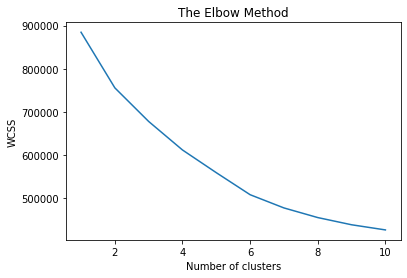

In [140]:
# Plotting the elbow curve to decide how many clusters to take
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_copy)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [141]:
# The optimal number of cluster is 6, we fit the data to the K-Means algorithm to find the clusters
km = KMeans(n_clusters=6)
km.fit(X_copy)
km.predict(X_copy)
labels = km.labels_

In [143]:
# Predicting the cluster segments
y_kmeans = km.fit_predict(X_copy)

In [147]:
# Add the cluster to the dataframe
X_copy['Cluster Labels'] = labels
X_copy['Segment'] = X_copy['Cluster Labels'].map({0:'First', 1:'Second',2:'Third',3:'Fourth',4:'Fifth',5: 'Sixth'})
# Order the clusters
X_copy['Segment'] = X_copy['Segment'].astype('category')
X_copy['Segment'] = X_copy['Segment'].cat.reorder_categories(['First','Second','Third','Fourth','Fifth','Sixth'])
X_copy.rename(columns = {'Cluster Labels':'Total'}, inplace = True)

In [149]:
# Transform back the standardized features
X_copy[cols_stand] = sc_X.inverse_transform(X_copy[cols_stand])

In [150]:
# Six clusters segment
cc0 = X_copy[X_copy['Segment'] == 'First']
cc1 = X_copy[X_copy['Segment'] == 'Second']
cc2 = X_copy[X_copy['Segment'] == 'Third']
cc3 = X_copy[X_copy['Segment'] == 'Fourth']
cc4 = X_copy[X_copy['Segment'] == 'Fifth']
cc5 = X_copy[X_copy['Segment'] == 'Sixth']

In [151]:
# Undummy function applied to the encoded categorical variables
def undummy(d):
    return d.dot(d.columns)
X_copy= X_copy.assign(Category=X_copy.filter(regex='^product_category_name').pipe(undummy),
                      Payment=X_copy.filter(regex='^payment_method').pipe(undummy),
                      Location=X_copy.filter(regex='^customer_autonomous_community').pipe(undummy))

In [153]:
# Drop columns 
cols_to_drop= ["payment_method_credit_card",
               'payment_method_debit_card',
               'payment_method_voucher',
               'product_category_name_automotive',
               'product_category_name_bakeware',
               'product_category_name_beauty & personal care',
               'product_category_name_bedroom decor',
               'product_category_name_book',
               'product_category_name_business office',
               'product_category_name_camera & photo',
               'product_category_name_cd vinyl',
               'product_category_name_ceiling fans',
               'product_category_name_cell phones',
               'product_category_name_cleaning supplies',
               'product_category_name_coffee machines',
               'product_category_name_comics',
               'product_category_name_computer accessories',
               'product_category_name_computers tablets',
               'product_category_name_diet sports nutrition',
               'product_category_name_dvd',
               'product_category_name_event & party supplies',
               'product_category_name_fabric',
               'product_category_name_fashion & shoes',
               'product_category_name_film & photography',
               'product_category_name_fire safety',
               'product_category_name_food',
               'product_category_name_fragrance',
               'product_category_name_furniture',
               'product_category_name_handbags & accessories',
               'product_category_name_hardware',
               'product_category_name_headphones',
               'product_category_name_health household',
               'product_category_name_home accessories',
               'product_category_name_home appliances',
               'product_category_name_home audio',
               'product_category_name_home emergency kits',
               'product_category_name_home lighting',
               'product_category_name_home security systems',
               'product_category_name_jewelry',
               'product_category_name_kids',
               'product_category_name_kids fashion',
               'product_category_name_kitchen & dining',
               'product_category_name_lawn garden',
               'product_category_name_light bulbs',
               'product_category_name_luggage',
               'product_category_name_mattresses & pillows',
               'product_category_name_medical supplies',
               "product_category_name_men's fashion",
               'product_category_name_model hobby building',
               'product_category_name_monitors',
               'product_category_name_music instruments',
               'product_category_name_office products',
               'product_category_name_oral care',
               'product_category_name_painting',
               'product_category_name_pet food',
               'product_category_name_pet supplies',
               'product_category_name_safety apparel',
               'product_category_name_seasonal decor',
               'product_category_name_sofa',
               'product_category_name_sport outdoors',
               'product_category_name_television & video',
               'product_category_name_tools home improvement',
               'product_category_name_toys games',
               'product_category_name_underwear',
               'product_category_name_videogame',
               'product_category_name_videogame console',
               'product_category_name_wall art',
               'product_category_name_watches',
               'product_category_name_wellness & relaxation',
               "product_category_name_woman's fashion",
               'customer_autonomous_community_Aragón',
               'customer_autonomous_community_Baleares',
               'customer_autonomous_community_Cantabria',
               'customer_autonomous_community_Castilla y León',
               'customer_autonomous_community_Castilla-La Mancha',
               'customer_autonomous_community_Cataluña',
               'customer_autonomous_community_Comunidad Foral de Navarra',
               'customer_autonomous_community_Comunidad Valenciana',
               'customer_autonomous_community_Comunidad de Madrid',
               'customer_autonomous_community_Extremadura',
               'customer_autonomous_community_Galicia',
               'customer_autonomous_community_Islas Canarias',
               'customer_autonomous_community_La Rioja',
               'customer_autonomous_community_País Vasco',
               'customer_autonomous_community_Principado de Asturias',
               'customer_autonomous_community_Región de Murcia']
X_copy= X_copy.drop(columns= cols_to_drop)

In [156]:
# Summary of the clusters, choosing mean for numerical columns and mode for categorical ones
clusters3 = X_copy.groupby('Segment').agg(
    {
        'Total':'count',
        'Category': lambda x: x.value_counts().index[0],
        'Payment': lambda x: x.value_counts().index[0],
        'Location':lambda x: x.value_counts().index[0],
        'price': 'mean',
        'shipping_cost': 'mean',
        'max_order': 'mean',
        'review_score': 'mean',
        'product_photo_quantity': 'mean',
        'transaction_value':'mean',
        'payment_installments_quantity':'mean'
    }
).reset_index()
clusters3 

,Segment,Total,Category,Payment,Location,price,shipping_cost,max_order,review_score,product_photo_quantity,transaction_value,payment_installments_quantity
0,First,48403,product_category_name_kitchen & dining,payment_method_credit_card,customer_autonomous_community_Comunidad de Madrid,83.606725,17.484125,1.095573,4.754230,1.521641,102.603700,1.783567
1,Second,14456,product_category_name_sport outdoors,payment_method_credit_card,customer_autonomous_community_Comunidad de Madrid,97.225835,18.261750,1.080589,4.466588,5.425360,115.381136,2.082111
2,Third,17538,product_category_name_kitchen & dining,payment_method_credit_card,customer_autonomous_community_Comunidad de Madrid,91.861563,18.239182,1.103033,1.727335,1.881400,112.190237,2.110731
3,Fourth,2003,product_category_name_jewelry,payment_method_credit_card,customer_autonomous_community_Comunidad de Madrid,1082.734423,68.039051,1.111832,4.078382,2.828757,1184.360654,6.201198
4,Fifth,3174,product_category_name_kitchen & dining,payment_method_credit_card,customer_autonomous_community_Comunidad de Madrid,71.627527,17.330888,3.889729,4.122558,1.781348,336.892606,3.917139
5,Sixth,14618,product_category_name_kitchen & dining,payment_method_credit_card,customer_autonomous_community_Comunidad de Madrid,209.908061,27.524172,1.149952,4.334724,1.957518,255.784839,7.548023


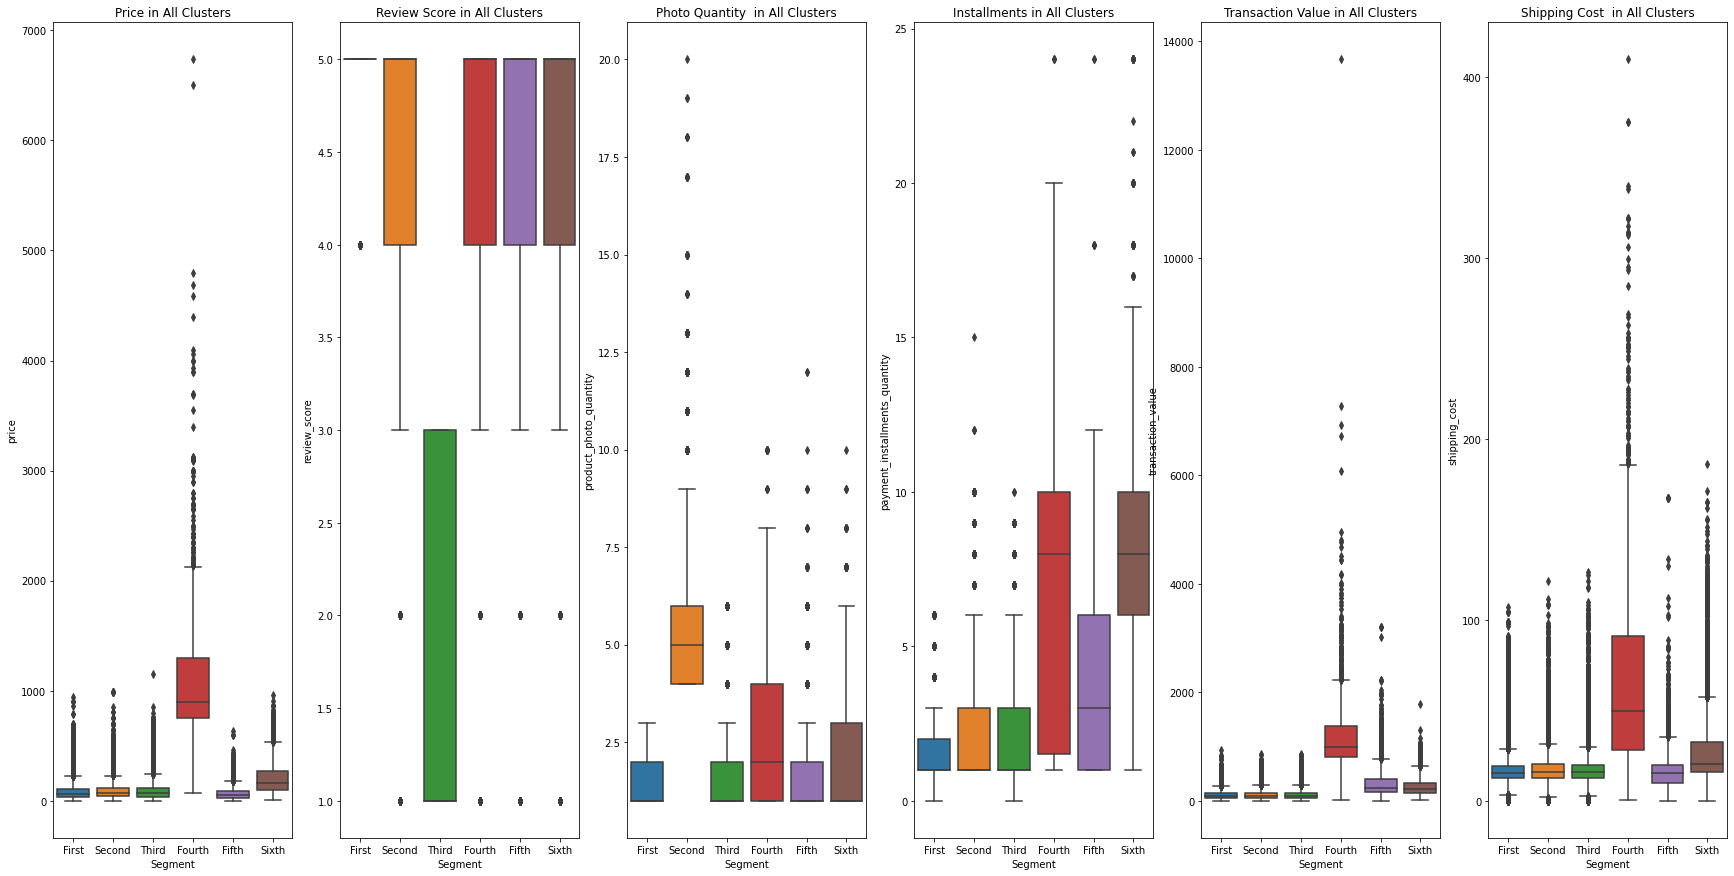

In [166]:
# Create boxplots to the distribution of the variables in each cluster
fig, axes = plt.subplots(1, 6, figsize=(30,15))
ax = sns.boxplot(ax=axes[0], x="Segment", y="price", data=X_copy)
ax.title.set_text('Price in All Clusters')
ax2 = sns.boxplot(ax=axes[1], x="Segment", y="review_score", data=X_copy)
ax2.title.set_text('Review Score in All Clusters')
ax3 = sns.boxplot(ax=axes[2], x="Segment", y="product_photo_quantity", data=X_copy)
ax3.title.set_text('Photo Quantity  in All Clusters')
ax4 = sns.boxplot(ax=axes[3], x="Segment", y="payment_installments_quantity", data=X_copy)
ax4.title.set_text('Installments in All Clusters')
ax5 = sns.boxplot(ax=axes[4], x="Segment", y="transaction_value", data=X_copy)
ax5.title.set_text('Transaction Value in All Clusters')
ax6 = sns.boxplot(ax=axes[5], x="Segment", y="shipping_cost", data=X_copy)
ax6.title.set_text('Shipping Cost  in All Clusters')
plt.show()